# Figure 1

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import mannwhitneyu

In [2]:
# Replace with the path to where you store data
DATA_PATH = "../../cnt-data/"

## Figure 1 (A)

In [3]:
# This is the example patient's HUP ID
patient_hup_id = 142

# Load in the patient's "giant table"
hourly_patient_features_df = pd.read_csv(
    os.path.join(DATA_PATH, f"giant_new_tables/HUP_{str(patient_hup_id)}.csv")
)

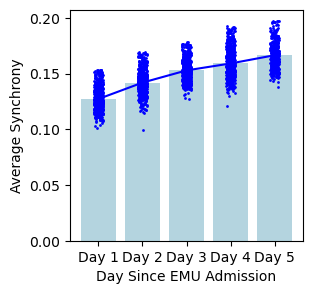

In [4]:
# Assuming you have hourly_patient_features_df and hup_id from somewhere above
taper_start_idx = hourly_patient_features_df[
    ~hourly_patient_features_df["synchrony_broadband"].isna()
].index[0]
taper_end_idx = hourly_patient_features_df[
    hourly_patient_features_df["had_seizure"] >= 1
].index[0]

taper_period = hourly_patient_features_df.loc[taper_start_idx:taper_end_idx]

# Given each row represents 2 minutes, there are 720 rows per day
rows_per_day = 720

day_avgs = []
day_data_list_of_lists = []
days = len(taper_period) // rows_per_day + 1  # Number of days (rounded up)
for i in range(days):
    day_data = taper_period["synchrony_broadband"].iloc[
        i * rows_per_day : (i + 1) * rows_per_day
    ]
    # Drop values in day_data that are larger than 95th percentile
    day_data = day_data[day_data < day_data.quantile(0.95)]
    top_half_data = day_data.dropna().nlargest(rows_per_day // 2)
    day_avgs.append(np.nanmean(day_data))
    day_data_list_of_lists.append(day_data)

plt.figure(figsize=(3, 3))  # Create a standalone figure

# Plot the bars
sns.barplot(x=list(range(1, days + 1)), y=day_avgs, errorbar="sd", color="lightblue")

# Plot the individual data points using stripplot
for i, day_data in enumerate(day_data_list_of_lists):
    sns.stripplot(
        x=[i + 1] * len(day_data), y=day_data, color="blue", size=2, jitter=True
    )

# Plot trend line connecting the bars, with marker size being large"
plt.plot(range(days), day_avgs, marker="o", linestyle="-", color="blue")

plt.xlabel("Day Since EMU Admission")
plt.xticks(range(days), [f"Day {i+1}" for i in range(days)])
plt.ylabel("Average Synchrony")
# plt.title("Daily Synchrony during Taper Period")
plt.show()  # Display the plot

(A) The daily synchrony value increases daily after the patient was admitted to the EMU and ASMs were tapered.

## Figure 1 (B)

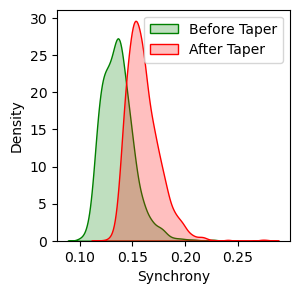

In [5]:
plt.figure(figsize=(3, 3))

# Fetch the taper_start_time for this patient
taper_start_time = 5000

# Define the first seizure time after taper_start_time
first_seizure_time = hourly_patient_features_df[
    (hourly_patient_features_df["emu_minute"] > taper_start_time)
    & (hourly_patient_features_df["had_seizure"] >= 1)
]["emu_minute"].min()

# Get 'after' period (time between taper_start_time and first_seizure_time)
after_period = hourly_patient_features_df[
    (hourly_patient_features_df["emu_minute"] >= taper_start_time)
    & (hourly_patient_features_df["emu_minute"] < first_seizure_time)
]
after_synchronies = after_period["synchrony_broadband"].values

# Determine the 'before' period based on the length of the 'after' period
# Ensure that we remove any rows with NaN values in 'synchrony_broadband'
before_period = hourly_patient_features_df[
    (hourly_patient_features_df["emu_minute"] < taper_start_time)
    & (~hourly_patient_features_df["synchrony_broadband"].isna())
].tail(len(after_synchronies))
before_synchronies = before_period["synchrony_broadband"].values

sns.kdeplot(before_synchronies, fill=True, color="green", label="Before Taper")
sns.kdeplot(after_synchronies, fill=True, color="red", label="After Taper")

plt.xlabel("Synchrony")
plt.ylabel("Density")
# plt.title("ASM Taper Shifts Synchrony Distribution")
plt.legend()
plt.show()

(B) The overall distribution of all synchrony values before and after ASM taper shifts right.

## Figure 1 (C)

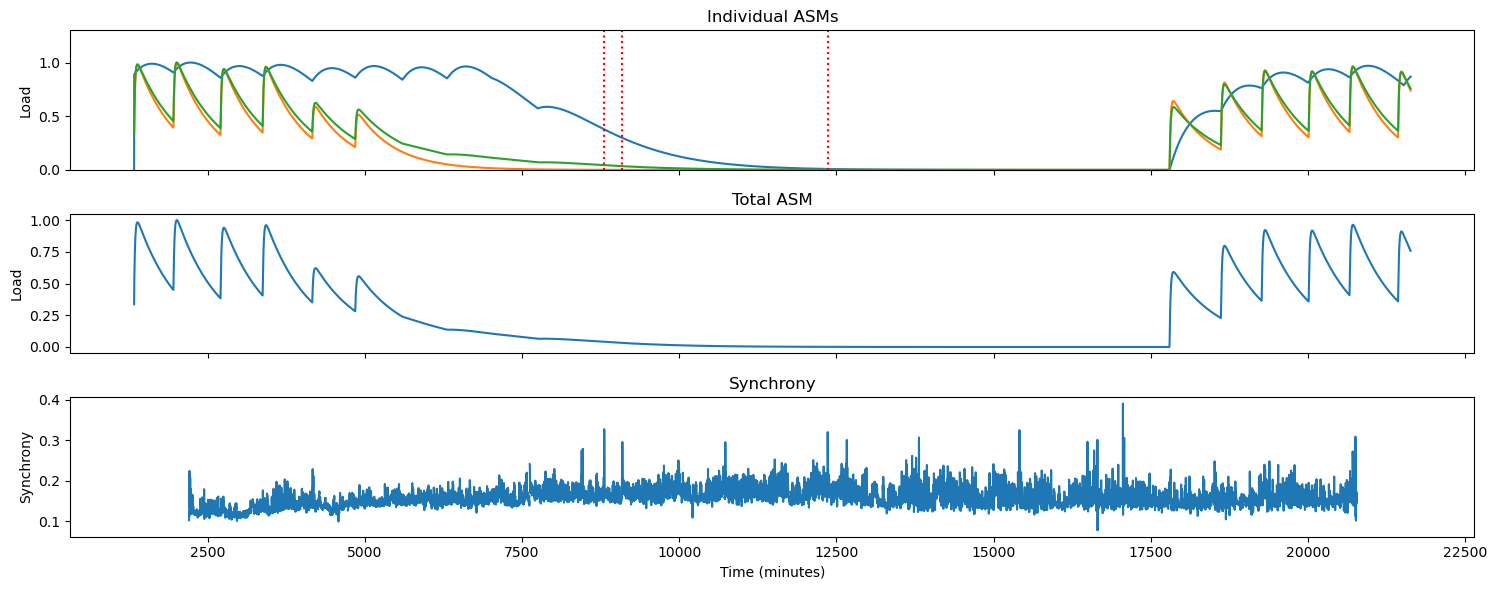

In [6]:
med_cols = [
    col
    for col in hourly_patient_features_df.columns
    if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
]
med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

fig, ax = plt.subplots(3, 1, figsize=(15, 6), sharex=True)

# Plotting Individual ASMs
for i, col in enumerate(med_cols):
    if col != "med_sum_no_lorazepam_raw":
        label = med_cols_no_raw[i].replace("med_", "")
        normalized_data = (
            hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
        )
        ax[0].plot(
            hourly_patient_features_df["emu_minute"], normalized_data, label=label
        )

seizure_minutes = hourly_patient_features_df[
    hourly_patient_features_df["had_seizure"] >= 1
]["emu_minute"].values
for idx in seizure_minutes:
    ax[0].axvline(x=idx, color="red", linestyle="dotted")

ax[0].set_ylabel("Load")
ax[0].set_ylim([0, 1.3])
# ax[0].legend()
ax[0].set_title("Individual ASMs")

ax[1].plot(
    hourly_patient_features_df["emu_minute"],
    hourly_patient_features_df["med_sum_no_lorazepam_raw"],
)
ax[1].set_ylabel("Load")
ax[1].set_title("Total ASM")

# Plotting synchrony (broadband Band)
ax[2].plot(
    hourly_patient_features_df["emu_minute"],
    hourly_patient_features_df["synchrony_broadband"],
)
ax[2].set_ylabel("Synchrony")
ax[2].set_title("Synchrony")

ax[2].set_xlabel("Time (minutes)")
plt.tight_layout()
plt.show()

## Figure 1 (D)

In [16]:
# Load taper_annotations.csv from the data directory
taper_df = pd.read_csv(os.path.join(DATA_PATH, "taper_annotations.csv"))
# Drop rows with any missing values in taper_start_hr
taper_df = taper_df.dropna(subset=["taper_start_hr"])
# Drop the reinit_start_hr column
taper_df = taper_df.drop(columns=["reinit_start_hr"])
taper_df

,hup_id,taper_start_hr
0,140,80.0
1,142,75.0
2,143,75.0
3,145,100.0
4,151,80.0
5,152,120.0
6,160,100.0
7,163,75.0
8,164,60.0
9,165,100.0


In [17]:
len(taper_df)

16

In [18]:
# Assuming taper_df and hourly_patient_features_df are already defined and loaded with data.

# Initialize dictionaries to store synchrony values for each hup_id
before_synchronies_dict = {}
after_synchronies_dict = {}

# Sort the hup_ids in ascending order and create a mapping to new indices
unique_hup_ids = sorted(taper_df["hup_id"].unique())
hup_id_to_index = {hup_id: index for index, hup_id in enumerate(unique_hup_ids)}

# Iterate through each row in the dataframe to collect synchrony values
for index, row in taper_df.iterrows():
    hup_id = int(row["hup_id"])
    taper_start_hr = int(row["taper_start_hr"])
    taper_start_time = taper_start_hr * 60

    hourly_patient_features_df = pd.read_csv(
        os.path.join(DATA_PATH, f"giant_new_tables/HUP_{str(patient_hup_id)}.csv")
    )

    first_seizure_time = hourly_patient_features_df[
        (hourly_patient_features_df["emu_minute"] > taper_start_time)
        & (hourly_patient_features_df["had_seizure"] >= 1)
    ]["emu_minute"].min()

    after_period = hourly_patient_features_df[
        (hourly_patient_features_df["emu_minute"] >= taper_start_time)
        & (hourly_patient_features_df["emu_minute"] < first_seizure_time)
    ]
    after_synchronies = after_period["synchrony_broadband"].values

    before_period = hourly_patient_features_df[
        (hourly_patient_features_df["emu_minute"] < taper_start_time)
        & (~hourly_patient_features_df["synchrony_broadband"].isna())
    ].tail(len(after_synchronies))
    before_synchronies = before_period["synchrony_broadband"].values

    before_synchronies = before_synchronies[~np.isnan(before_synchronies)]
    after_synchronies = after_synchronies[~np.isnan(after_synchronies)]

    # Store the 'before' and 'after' synchrony values in the corresponding dictionaries
    hup_index = hup_id_to_index[hup_id]  # Use the new index for even spacing
    if hup_index not in before_synchronies_dict:
        before_synchronies_dict[hup_index] = []
        after_synchronies_dict[hup_index] = []

    before_synchronies_dict[hup_index].extend(before_synchronies)
    after_synchronies_dict[hup_index].extend(after_synchronies)

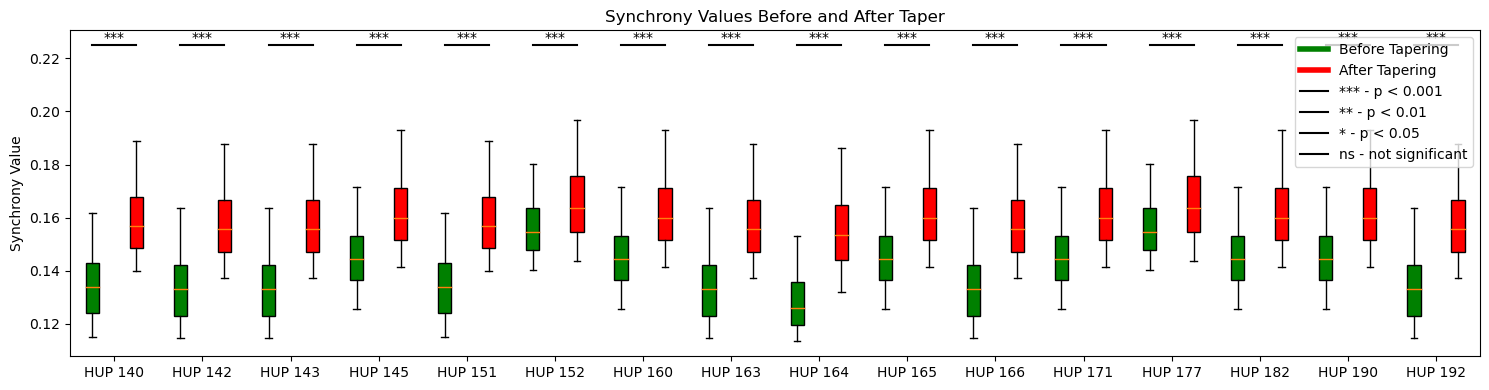

In [19]:
# Use matplotlib to create the boxplots in a wider figure
fig, ax = plt.subplots(figsize=(15, 4))  # Making the figure wider

# Define the percentile for the whiskers (e.g., 5th and 95th percentiles)
lower_whisker = 5
upper_whisker = 95

# You would have to iterate over your dictionaries to plot the 'before' and 'after' boxplots using the new indices
positions = []
labels = []
for hup_index in sorted(before_synchronies_dict.keys()):
    hup_id = unique_hup_ids[hup_index]  # Retrieve the actual hup_id for labeling
    # Calculate positions for 'before' and 'after' boxplots
    before_position = 2 * hup_index
    after_position = 2 * hup_index + 1
    # Center label position between 'before' and 'after'
    label_position = (before_position + after_position) / 2
    positions.append(label_position)
    labels.append(f"HUP {hup_id}")

    # Plot 'before' boxplot
    bp_before = ax.boxplot(
        before_synchronies_dict[hup_index],
        positions=[before_position],
        patch_artist=True,
        widths=0.3,
        showfliers=False,
        whis=[lower_whisker, upper_whisker],
    )
    plt.setp(bp_before["boxes"], facecolor="green")

    # Plot 'after' boxplot
    bp_after = ax.boxplot(
        after_synchronies_dict[hup_index],
        positions=[after_position],
        patch_artist=True,
        widths=0.3,
        showfliers=False,
        whis=[lower_whisker, upper_whisker],
    )
    plt.setp(bp_after["boxes"], facecolor="red")

    # Statistical test and significance annotation
    u_statistic, p_value = mannwhitneyu(
        before_synchronies_dict[hup_index],
        after_synchronies_dict[hup_index],
        alternative="two-sided",
    )
    sig = "ns"  # Default to not significant
    if p_value < 0.001:
        sig = "***"
    elif p_value < 0.01:
        sig = "**"
    elif p_value < 0.05:
        sig = "*"

    # Annotation at a fixed y-value
    annotation_y = 0.225
    ax.plot(
        [before_position, after_position],
        [annotation_y, annotation_y],
        lw=1.5,
        c="black",
    )
    ax.text(
        (before_position + after_position) / 2,
        annotation_y,
        sig,
        ha="center",
        va="bottom",
        color="black",
    )

# Adjusting x-axis labels
ax.set_ylabel("Synchrony Value")
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=0)  # Labels are now more concise
plt.title("Synchrony Values Before and After Taper")

# Updating the legend
legend_elements = [
    Line2D([0], [0], color="green", lw=4, label="Before Tapering"),
    Line2D([0], [0], color="red", lw=4, label="After Tapering"),
    Line2D([0], [0], color="black", lw=1.5, label="*** - p < 0.001"),
    Line2D([0], [0], color="black", lw=1.5, label="** - p < 0.01"),
    Line2D([0], [0], color="black", lw=1.5, label="* - p < 0.05"),
    Line2D([0], [0], color="black", lw=1.5, label="ns - not significant"),
]
ax.legend(handles=legend_elements, loc="upper right")

# Finalizing the plot
plt.tight_layout()
plt.show()

## Figure 1 (E)

In [28]:
# Load taper_annotations.csv from the data directory
reinit_df = pd.read_csv(os.path.join(DATA_PATH, "taper_annotations.csv"))
# Drop rows with any missing values in taper_start_hr
reinit_df = reinit_df.dropna(subset=["reinit_start_hr"])
# Drop the taper_start_hr column
reinit_df = reinit_df.drop(columns=["taper_start_hr"])
# reset the index
reinit_df = reinit_df.reset_index(drop=True)
reinit_df

,hup_id,reinit_start_hr
0,140,185.0
1,142,285.0
2,145,275.0
3,152,380.0
4,163,290.0
5,166,170.0
6,171,210.0
7,173,210.0
8,177,200.0
9,190,300.0


In [45]:
# Remove the row with hup_id == 152
reinit_df = reinit_df[reinit_df["hup_id"] != 152]

In [46]:
len(reinit_df)

9

In [47]:
# Initialize dictionaries to store synchrony values for each hup_id
before_synchronies_dict = {}
after_synchronies_dict = {}

# Sort the hup_ids in ascending order and create a mapping to new indices
unique_hup_ids = sorted(reinit_df["hup_id"].unique())
hup_id_to_index = {hup_id: index for index, hup_id in enumerate(unique_hup_ids)}

In [51]:
# Iterate through each row in the dataframe to collect synchrony values
for index, row in reinit_df.iterrows():
    hup_id = int(row["hup_id"])
    reinit_start_hr = int(row["reinit_start_hr"])
    reinit_start_time = reinit_start_hr * 60

    hourly_patient_features_df = pd.read_csv(
        os.path.join(DATA_PATH, f"giant_new_tables/HUP_{str(patient_hup_id)}.csv")
    )

    before_period = hourly_patient_features_df[
        (hourly_patient_features_df["emu_minute"] < reinit_start_time)
        & (~hourly_patient_features_df["synchrony_broadband"].isna())
    ].tail(720)
    before_synchronies = before_period["synchrony_broadband"].values

    after_period = hourly_patient_features_df[
        (hourly_patient_features_df["emu_minute"] >= reinit_start_time)
        & (~hourly_patient_features_df["synchrony_broadband"].isna())
    ].head(720)
    after_synchronies = after_period["synchrony_broadband"].values

    before_synchronies = before_synchronies[~np.isnan(before_synchronies)]
    after_synchronies = after_synchronies[~np.isnan(after_synchronies)]

    # Store the 'before' and 'after' synchrony values in the corresponding dictionaries
    hup_index = hup_id_to_index[hup_id]  # Use the new index for even spacing
    if hup_index not in before_synchronies_dict:
        before_synchronies_dict[hup_index] = []
        after_synchronies_dict[hup_index] = []

    before_synchronies_dict[hup_index].extend(before_synchronies)
    after_synchronies_dict[hup_index].extend(after_synchronies)

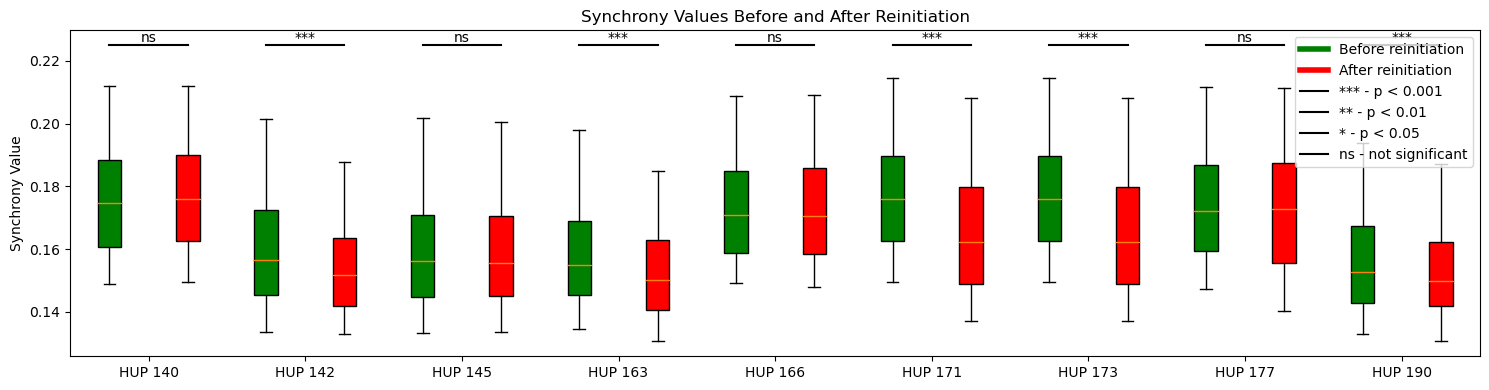

In [52]:
# Use matplotlib to create the boxplots in a wider figure
fig, ax = plt.subplots(figsize=(15, 4))  # Making the figure wider

# Define the percentile for the whiskers (e.g., 5th and 95th percentiles)
lower_whisker = 5
upper_whisker = 95

# You would have to iterate over your dictionaries to plot the 'before' and 'after' boxplots using the new indices
positions = []
labels = []
for hup_index in sorted(before_synchronies_dict.keys()):
    hup_id = unique_hup_ids[hup_index]  # Retrieve the actual hup_id for labeling
    # Calculate positions for 'before' and 'after' boxplots
    before_position = 2 * hup_index
    after_position = 2 * hup_index + 1
    # Center label position between 'before' and 'after'
    label_position = (before_position + after_position) / 2
    positions.append(label_position)
    labels.append(f"HUP {hup_id}")

    # Plot 'before' boxplot
    bp_before = ax.boxplot(
        before_synchronies_dict[hup_index],
        positions=[before_position],
        patch_artist=True,
        widths=0.3,
        showfliers=False,
        whis=[lower_whisker, upper_whisker],
    )
    plt.setp(bp_before["boxes"], facecolor="green")

    # Plot 'after' boxplot
    bp_after = ax.boxplot(
        after_synchronies_dict[hup_index],
        positions=[after_position],
        patch_artist=True,
        widths=0.3,
        showfliers=False,
        whis=[lower_whisker, upper_whisker],
    )
    plt.setp(bp_after["boxes"], facecolor="red")

    # Statistical test and significance annotation
    u_statistic, p_value = mannwhitneyu(
        before_synchronies_dict[hup_index],
        after_synchronies_dict[hup_index],
        alternative="two-sided",
    )
    sig = "ns"  # Default to not significant
    if p_value < 0.001:
        sig = "***"
    elif p_value < 0.01:
        sig = "**"
    elif p_value < 0.05:
        sig = "*"

    # Annotation at a fixed y-value
    annotation_y = 0.225
    ax.plot(
        [before_position, after_position],
        [annotation_y, annotation_y],
        lw=1.5,
        c="black",
    )
    ax.text(
        (before_position + after_position) / 2,
        annotation_y,
        sig,
        ha="center",
        va="bottom",
        color="black",
    )

# Adjusting x-axis labels
ax.set_ylabel("Synchrony Value")
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=0)  # Labels are now more concise
plt.title("Synchrony Values Before and After Reinitiation")

# Updating the legend
legend_elements = [
    Line2D([0], [0], color="green", lw=4, label="Before reinitiation"),
    Line2D([0], [0], color="red", lw=4, label="After reinitiation"),
    Line2D([0], [0], color="black", lw=1.5, label="*** - p < 0.001"),
    Line2D([0], [0], color="black", lw=1.5, label="** - p < 0.01"),
    Line2D([0], [0], color="black", lw=1.5, label="* - p < 0.05"),
    Line2D([0], [0], color="black", lw=1.5, label="ns - not significant"),
]
ax.legend(handles=legend_elements, loc="upper right")

# Finalizing the plot
plt.tight_layout()
plt.show()